---

---

<div style="text-align: center;">
    <img src="ensae.png" alt="ENSAE Logo" style="width: 150px;"/>
</div>

<div style="text-align: center; font-size: 14px;">
    École nationale de la Statistique et de l'Analyse économique Pierre NDIAYE <br>
    ENSAE - Dakar
</div>

<div style="border-top: 2px solid black; margin: 20px 0;"></div>

<div style="text-align: center; font-size: 20px; font-weight: bold;">
    Projet de Machine Learning
</div>

<div style="border-top: 2px solid black; margin: 20px 0;"></div>

<div style="text-align: center;">
    <img src="seattle_image.png" alt="Seattle Consulting Logo" style="width: 300px;"/>
</div>

<div style="text-align: center; font-size: 24px; font-weight: bold; margin-top: 20px;">
    SEA Building CO2 Benchmarking : Prédiction de l’émission du CO2 <br>
    Partie Modélisation
</div>

<div style="display: flex; justify-content: space-between; margin-top: 40px;">
    <div style="text-align: left; width: 45%;">
        <strong>Présenté par :</strong><br>
        Koffi Samson AWOUTO <br>
        Harouna GOUMBANE<br>
        Inoussa ZAONGO<br>
        Zoumana ZERBO
    </div>
    <div style="text-align: right; width: 45%;">
        <strong>Sous l'encadrement de :</strong><br>
        Mously DIAW
    </div>
</div>

<div style="text-align: center; margin-top: 40px;">
    Décembre 2024
</div>


# Sommaire

1. [I. Importation des librairies necessaire](#import1)
2. [II. Importation de la base traitée ](#import2)
3. [III. Préparation des jeux d'entrainement et de test](#prepa)
4. [IV. Evaluation des modèles sur nos jeux de données train (80%) et Test (20%)](#evaluation)
5. [V. Comparaison des modèles à travers une validation croisée](#compare)
6. [VI. Amelioration  du meilleur modèle : Random Forest](#amelioration)


# I. Importation des librairies necessaire <a id="import1"></a>

In [1525]:
# Standard Python Libraries
import time
from pathlib import Path
from scipy.stats import normaltest

# Data Manipulation and Analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Scikit-learn (Machine Learning)
from sklearn import set_config
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, make_scorer, r2_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, ElasticNet, SGDRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, learning_curve, KFold
from sklearn.pipeline import make_pipeline, Pipeline

# XGBoost
from xgboost import XGBRegressor

# Statistical Analysis
from scipy.stats import *
import statsmodels.stats.diagnostic as smsd

# Yellowbrick (Visualization for Machine Learning)
from yellowbrick.model_selection import LearningCurve, ValidationCurve
from yellowbrick.regressor import ResidualsPlot, PredictionError, CooksDistance

# Data Profiling
from ydata_profiling import ProfileReport


# II. Importation de la base traitée <a id="import2"></a>

In [1527]:
data = pd.read_csv("Final_data.csv", sep=",")

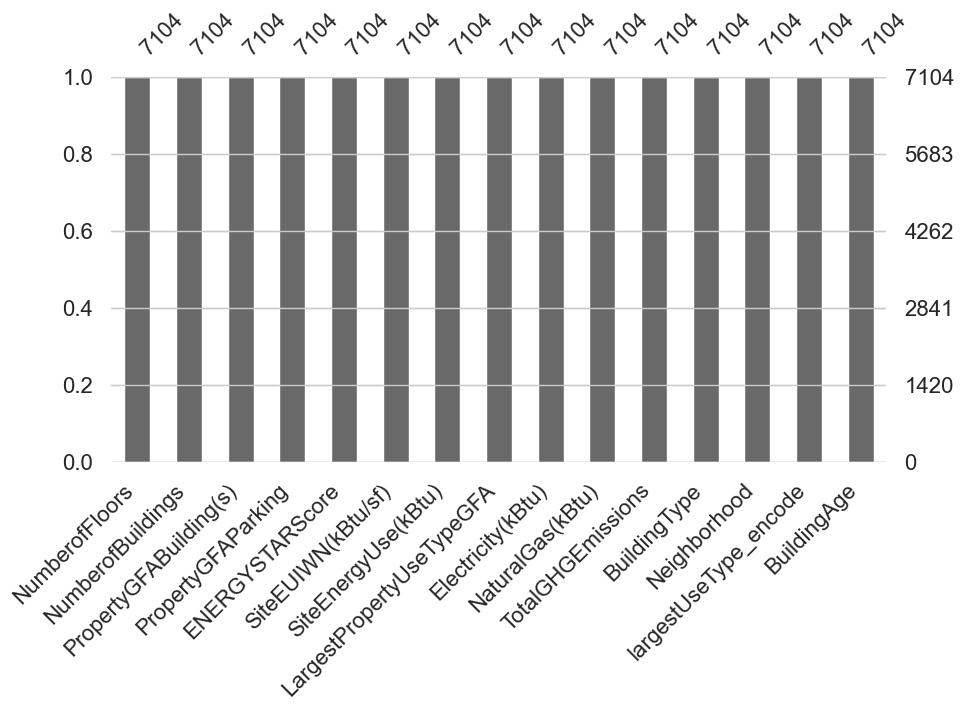

In [1528]:
# A bar chart visualization of the nullity of the given DataFrame.
msno.bar(data, figsize=(10, 5));

## Normalité de la variable cible <a class="anchor" id="normality"></a>

notre variable cible TotalGHGEmissions suit-elle une tendance normale?

In [1531]:
Y= data[['TotalGHGEmissions']]
X= data.drop(['TotalGHGEmissions'], axis=1)


### Pourquoi la normalité

In [1533]:

# Charger les données dans un DataFrame (remplacez 'data.csv' par votre fichier)
# df = pd.read_csv('data.csv')

# Calcul de l'écart type de la variable cible TotalGHGEmissions
ecart_type = Y['TotalGHGEmissions'].std()

# Afficher le résultat
print(f"L'écart type de la variable TotalGHGEmissions est : {ecart_type}")


L'écart type de la variable TotalGHGEmissions est : 594.4997045477752


L'ecart type de notre variable cible étant élévé et de plus la variable à une distribution asymetrique ,nous allons utiliser une transformation pour diminuer la variabilité de celle-ci

### une première transformation : log

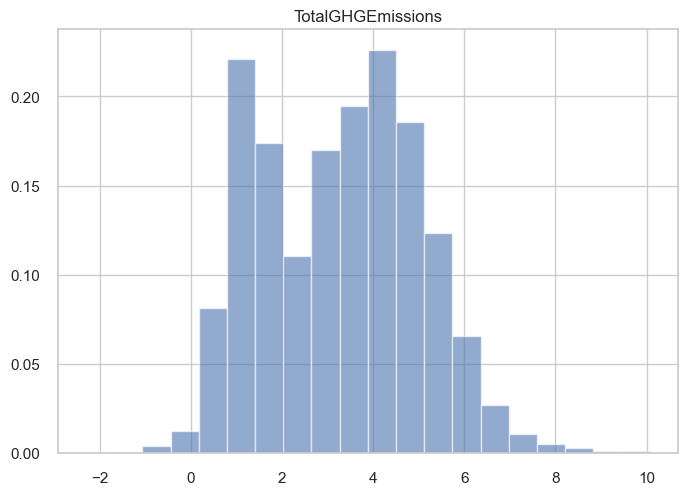

In [1536]:
logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
Y_log = logtransformer.transform(Y)
Y_log.hist(bins=20, density=True, alpha=0.6, color='b')  
plt.show()

On constate que la distribution tend vers une distribution normale

### Test de normalité

In [1539]:

# Supposons que Y soit la variable cible (une seule variable)
statistic, p_value = normaltest(Y)

if p_value < 0.05:
    print("La distribution de la variable TotalGHGEmissions n'est pas normale")
else:
    print("La distribution de la variable est normale")


La distribution de la variable TotalGHGEmissions n'est pas normale


Le test de normalité viens confirmer que cette transformation n'est pas normale

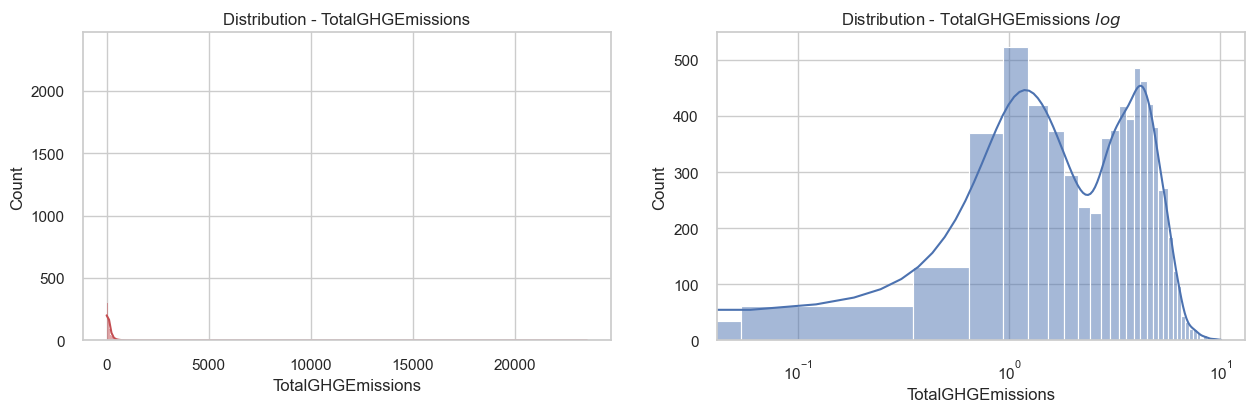

In [1541]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

sns.histplot(data["TotalGHGEmissions"], color='r', kde=True, ax=axes[0])
axes[0].set_title('Distribution - TotalGHGEmissions')

sns.histplot(np.log(data["TotalGHGEmissions"]), color='b', kde=True, ax=axes[1])
axes[1].set_title('Distribution - TotalGHGEmissions $log$')
axes[1].set_xscale('log');

### D'autres transformation 

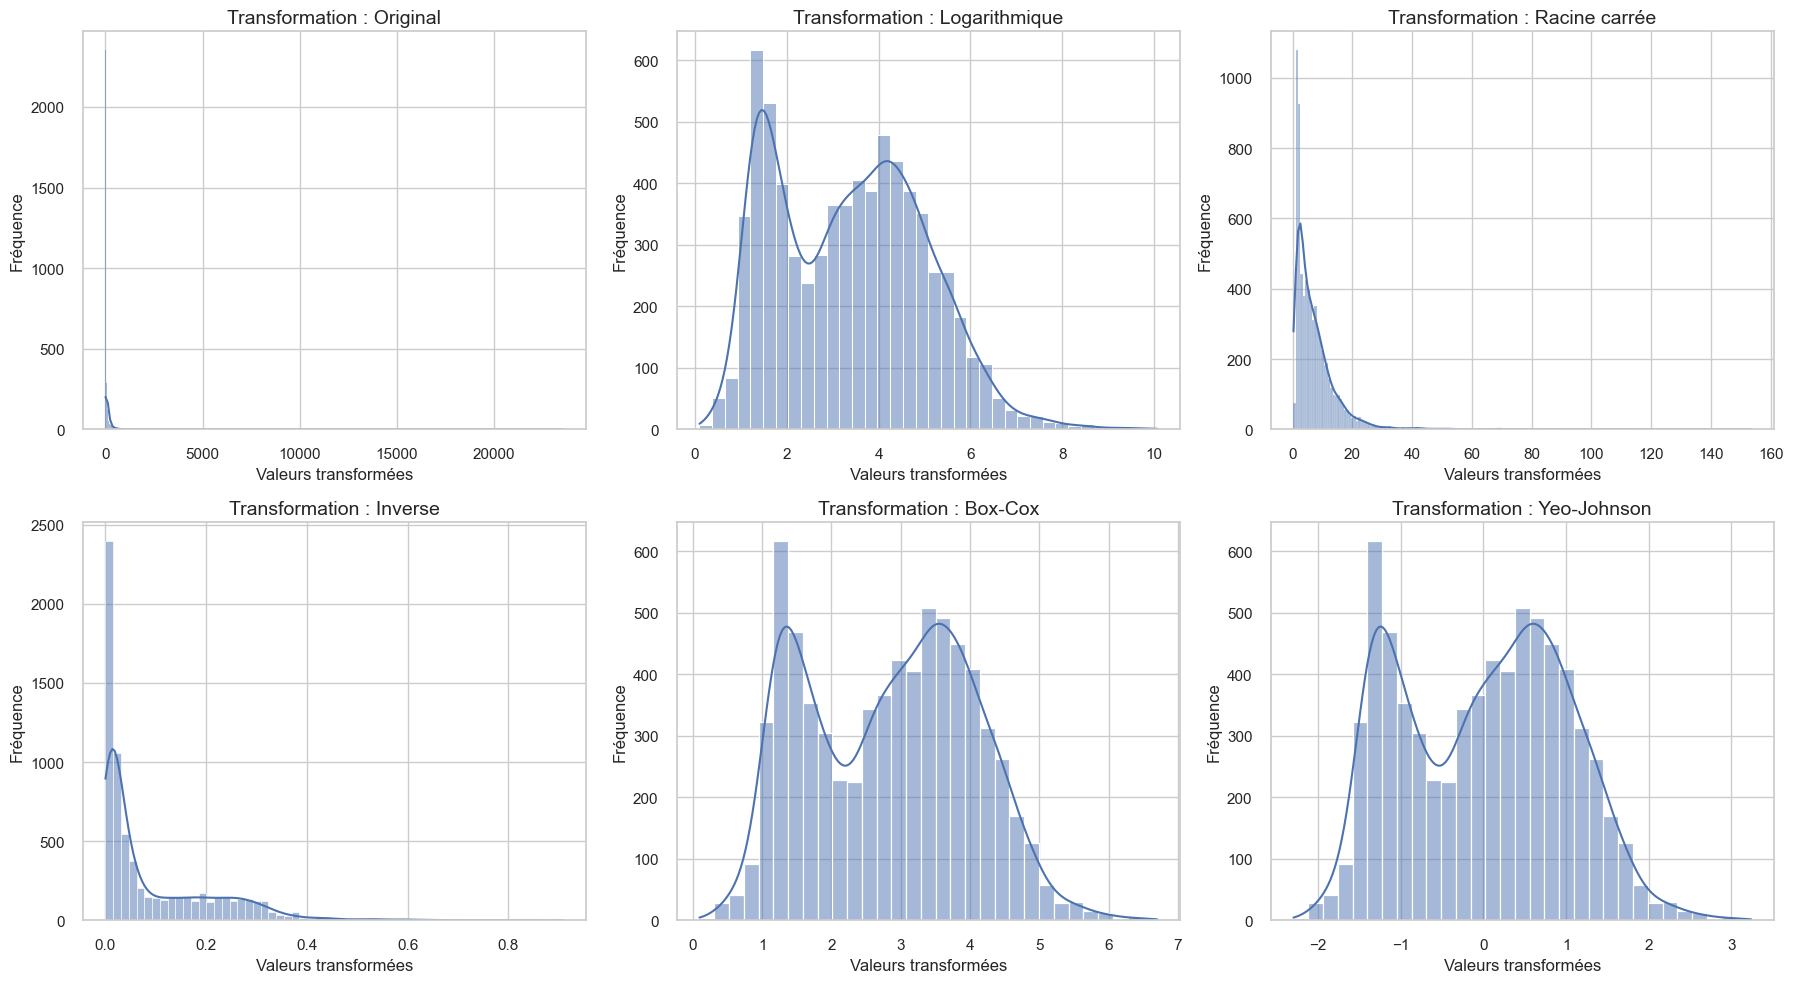

In [1543]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer

# Données de la variable cible (exemple)
variable_cible = data["TotalGHGEmissions"]

# Initialisation des transformations
transformations = {
    'Original': variable_cible,
    'Logarithmique': np.log(variable_cible + 1),  # Ajout de 1 pour éviter log(0)
    'Racine carrée': np.sqrt(variable_cible),
    'Inverse': 1 / (variable_cible + 1),  # Ajout de 1 pour éviter division par 0
}

# Transformation Box-Cox (ne fonctionne que sur des valeurs strictement positives)
variable_positive = variable_cible + 1  # S'assurer que toutes les valeurs sont > 0
transformations['Box-Cox'], _ = boxcox(variable_positive)

# Transformation Yeo-Johnson (fonctionne avec valeurs négatives)
yeo_johnson_transformer = PowerTransformer(method='yeo-johnson')
transformations['Yeo-Johnson'] = yeo_johnson_transformer.fit_transform(variable_cible.values.reshape(-1, 1)).flatten()

# Affichage des distributions
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, (name, transformed) in enumerate(transformations.items()):
    sns.histplot(transformed, kde=True, ax=axes[i], color='b')
    axes[i].set_title(f"Transformation : {name}", fontsize=14)
    axes[i].set_xlabel('Valeurs transformées', fontsize=12)
    axes[i].set_ylabel('Fréquence', fontsize=12)

# Supprimer les axes inutilisés si nécessaire
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajuster l'espace entre les graphiques
plt.tight_layout()
plt.show()


Toute les transformations ne donne pas de distribution normale , Nous allons donc utiliser la transformation log dans la suite  qui se rapproche un peu d'une distribution normale.

 # III. Préparation des jeux d'entrainement et de test ¶<a id="prepa"></a>
Afin de tester notre meilleur modèle sur des données "inconnues", nous allons subdiviser (split) notre jeu de données en deux parties pour obtenir un jeu d'entrainement et un jeu de test (20% des données)

In [1546]:
# Création d'une nouvelle colonne pour stocker le log des valeurs positives
data['Log_TotalGHGEmissions'] = np.log(data['TotalGHGEmissions'].replace(0, np.nan)).dropna()
#data['Log_TotalGHGEmissions'] = np.sqrt(data['TotalGHGEmissions'])

# Vérification du résultat
print(data[['TotalGHGEmissions', 'Log_TotalGHGEmissions']].head())


   TotalGHGEmissions  Log_TotalGHGEmissions
0              241.6               5.487283
1              135.4               4.908233
2             1201.4               7.091243
3              208.6               5.340419
4              380.4               5.941223


In [1547]:
log_y= data[['Log_TotalGHGEmissions']].squeeze()
X= data.drop(['TotalGHGEmissions','Log_TotalGHGEmissions'], axis=1)

### Separation

In [1549]:
# === Étape 1 : Séparation des données ===
X_train, X_test, Y_train, Y_test = train_test_split(X, log_y, test_size=0.2, random_state=42)
   

### Standardisation

In [1551]:
 # === Étape 2 : Standardisation après séparation ===
scaler = StandardScaler()         
            # Standardisation des données d'entraînement et de test
X_train_scaled = scaler.fit_transform(X_train)  # Apprend les paramètres sur train
X_test_scaled = scaler.transform(X_test)       # Applique les mêmes paramètres sur test
  

# IV. Evaluation des modèles sur nos jeux de données train (80%) et Test (20%) <a id="evaluation"></a>

## Un premier modèle : la Régression linéaire -- LinearRegression() 

In [1554]:

# === Étape 1 : Création et entraînement du modèle ===
model = LinearRegression()
model.fit(X_train_scaled, Y_train)

# === Étape 2 : Prédiction et évaluation ===
y_pred = model.predict(X_test_scaled)

# Calcul des scores et métriques
print("Score d'entraînement =", model.score(X_train_scaled, Y_train))
print("Score de la prédiction =", model.score(X_test_scaled, Y_test))
print("Ecart absolu moyen =", mean_absolute_error(Y_test, y_pred))
print("Racine carrée de l'erreur quadratique moyenne =", np.sqrt(mean_squared_error(Y_test, y_pred)))
print("Erreur absolue médiane =", median_absolute_error(Y_test, y_pred))


Score d'entraînement = 0.5304293164286489
Score de la prédiction = 0.51877640406388
Ecart absolu moyen = 1.0138439456862056
Racine carrée de l'erreur quadratique moyenne = 1.1986231973932282
Erreur absolue médiane = 0.9496940832229435


Le Score d'entraînement de 0.53 indique que le modèle de régression linéaire capture environ 52.9 % de la variance des données cibles dans l'ensemble d'entraînement. Cela montre que le modèle est capable d'apprendre une partie des relations entre les variables explicatives et la cible, bien que ses performances soient limitées.

Ce résultat est cohérent avec le Score de prédiction de 0.53, qui reflète la capacité du modèle à généraliser sur de nouvelles données. La proximité entre ces deux scores suggère que le modèle ne souffre ni de surapprentissage ni de sous-apprentissage. Ainsi, il est bien équilibré pour les données d'entraînement et de test, ce qui témoigne d'une généralisation correcte des résultats à des données inconnues.
Le modèle de régression linéaire offre une première approximation correcte mais limitée de la relation entre les variables explicatives et Log_TotalGHGEmissions. Dans la suite nous allons implanté d'autre modèle , lineaire et non lineaire afin de choisir le meilleur modèle pour predire l'emission du CO2.

 ## Evaluation des modèles sur un premier échantillon sans la variable ENERGYSTARScore 

### Separation des données

In [1558]:
log_y= data[['Log_TotalGHGEmissions']].squeeze()
X1= data.drop(['TotalGHGEmissions','Log_TotalGHGEmissions','ENERGYSTARScore'], axis=1)

In [1559]:
# === Étape 1 : Séparation des données ===
X_train, X_test, Y_train, Y_test = train_test_split(X1, log_y, test_size=0.2, random_state=42)

### Standardisation

In [1561]:
 # === Étape 2 : Standardisation après séparation ===
scaler = StandardScaler()         
            # Standardisation des données d'entraînement et de test
X_train_scaled = scaler.fit_transform(X_train)  # Apprend les paramètres sur train
X_test_scaled = scaler.transform(X_test)       # Applique les mêmes paramètres sur test


### Resultats 

In [1563]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import time

# Liste des modèles
DiffModels = {
    'RandomForestRegressor': RandomForestRegressor(),
    'XGBRegressor': XGBRegressor(),
    'SGDRegressor': SGDRegressor(),
    'SVR': SVR(),
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=3),
    'Lasso': Lasso(tol=0.2),
    'ElasticNet': ElasticNet(),
}

# Initialiser la cible et les résultats
results = {}

# Séparer les données en train et test
X_train, X_test, Y_train, Y_test = train_test_split(X1, log_y, test_size=0.2, random_state=42)

# Initialiser le scaler
scaler = StandardScaler()

# Appliquer la standardisation sur les données d'entraînement et de test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Parcourir chaque modèle et calculer les métriques
for name, model_instance in DiffModels.items():
    print(f"\nModèle : {name}")
    start_time = time.time()  # Temps de départ

    # Entraîner le modèle
    model_instance.fit(X_train_scaled, Y_train)

    # Prédictions
    y_train_pred = model_instance.predict(X_train_scaled)
    y_test_pred = model_instance.predict(X_test_scaled)

    # Calcul des métriques
    train_r2 = r2_score(Y_train, y_train_pred)
    test_r2 = r2_score(Y_test, y_test_pred)
    mae = mean_absolute_error(Y_test, y_test_pred)
    mse = mean_squared_error(Y_test, y_test_pred)
    exec_time = time.time() - start_time

    # Stocker les résultats
    results[name] = {
        'train_r2': train_r2,
        'test_r2': test_r2,
        'MAE': mae,
        'MSE': mse,
        'execution_time': exec_time
    }

    # Afficher les résultats pour chaque modèle
    print(f"R² (Train): {train_r2:.4f}")
    print(f"R² (Test): {test_r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"Temps d'exécution: {exec_time:.4f} secondes")

# Afficher un résumé global des métriques
print("\n\nRésumé des performances des modèles :")
for model_name, metrics in results.items():
    print(f"{model_name} - R² Train: {metrics['train_r2']:.4f} | R² Test: {metrics['test_r2']:.4f} | "
          f"MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | Temps: {metrics['execution_time']:.4f} sec")



Modèle : RandomForestRegressor
R² (Train): 0.9853
R² (Test): 0.9045
MAE: 0.2331
MSE: 0.2852
Temps d'exécution: 5.3178 secondes

Modèle : XGBRegressor
R² (Train): 0.9932
R² (Test): 0.8961
MAE: 0.2634
MSE: 0.3101
Temps d'exécution: 0.3082 secondes

Modèle : SGDRegressor
R² (Train): 0.5212
R² (Test): 0.4987
MAE: 1.0216
MSE: 1.4967
Temps d'exécution: 0.0319 secondes

Modèle : SVR
R² (Train): 0.8219
R² (Test): 0.8025
MAE: 0.5066
MSE: 0.5897
Temps d'exécution: 5.1013 secondes

Modèle : LinearRegression
R² (Train): 0.5277
R² (Test): 0.5155
MAE: 1.0158
MSE: 1.4464
Temps d'exécution: 0.0060 secondes

Modèle : Ridge
R² (Train): 0.5277
R² (Test): 0.5155
MAE: 1.0159
MSE: 1.4466
Temps d'exécution: 0.0050 secondes

Modèle : Lasso
R² (Train): 0.0000
R² (Test): -0.0009
MAE: 1.4598
MSE: 2.9883
Temps d'exécution: 0.0051 secondes

Modèle : ElasticNet
R² (Train): 0.2555
R² (Test): 0.2500
MAE: 1.2889
MSE: 2.2392
Temps d'exécution: 0.0039 secondes


Résumé des performances des modèles :
RandomForestRegress

## Evaluation des modèles sur un premier échantillon avec la presence de la variable ENERGYSTARScore 
Nous allons utiliser la division fait plus haut de notre base de données en train = 80% et test= 20% , afin d'evaluer nos modèle sur cet echantillon.

In [1565]:


# Liste des modèles
DiffModels = {
    'RandomForestRegressor': RandomForestRegressor(),
    'XGBRegressor': XGBRegressor(),
    'SGDRegressor': SGDRegressor(),
    'SVR': SVR(),
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=3),
    'Lasso': Lasso(tol=0.2),
    'ElasticNet': ElasticNet(),
}

# Initialiser la cible et les résultats
results = {}

# Séparer les données en train et test
X_train, X_test, Y_train, Y_test = train_test_split(X, log_y, test_size=0.2, random_state=42)

# Initialiser le scaler
scaler = StandardScaler()

# Appliquer la standardisation sur les données d'entraînement et de test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Parcourir chaque modèle et calculer les métriques
for name, model_instance in DiffModels.items():
    print(f"\nModèle : {name}")
    start_time = time.time()  # Temps de départ

    # Entraîner le modèle
    model_instance.fit(X_train_scaled, Y_train)

    # Prédictions
    y_train_pred = model_instance.predict(X_train_scaled)
    y_test_pred = model_instance.predict(X_test_scaled)

    # Calcul des métriques
    train_r2 = r2_score(Y_train, y_train_pred)
    test_r2 = r2_score(Y_test, y_test_pred)
    mae = mean_absolute_error(Y_test, y_test_pred)
    mse = mean_squared_error(Y_test, y_test_pred)
    exec_time = time.time() - start_time

    # Stocker les résultats
    results[name] = {
        'train_r2': train_r2,
        'test_r2': test_r2,
        'MAE': mae,
        'MSE': mse,
        'execution_time': exec_time
    }

    # Afficher les résultats pour chaque modèle
    print(f"R² (Train): {train_r2:.4f}")
    print(f"R² (Test): {test_r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"Temps d'exécution: {exec_time:.4f} secondes")

# Afficher un résumé global des métriques
print("\n\nRésumé des performances des modèles :")
for model_name, metrics in results.items():
    print(f"{model_name} - R² Train: {metrics['train_r2']:.4f} | R² Test: {metrics['test_r2']:.4f} | "
          f"MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | Temps: {metrics['execution_time']:.4f} sec")



Modèle : RandomForestRegressor
R² (Train): 0.9857
R² (Test): 0.9059
MAE: 0.2309
MSE: 0.2808
Temps d'exécution: 5.6340 secondes

Modèle : XGBRegressor
R² (Train): 0.9938
R² (Test): 0.8957
MAE: 0.2729
MSE: 0.3113
Temps d'exécution: 0.3231 secondes

Modèle : SGDRegressor
R² (Train): 0.5263
R² (Test): 0.5180
MAE: 1.0161
MSE: 1.4389
Temps d'exécution: 0.0229 secondes

Modèle : SVR
R² (Train): 0.8237
R² (Test): 0.7992
MAE: 0.5114
MSE: 0.5994
Temps d'exécution: 5.4504 secondes

Modèle : LinearRegression
R² (Train): 0.5304
R² (Test): 0.5188
MAE: 1.0138
MSE: 1.4367
Temps d'exécution: 0.0050 secondes

Modèle : Ridge
R² (Train): 0.5304
R² (Test): 0.5187
MAE: 1.0139
MSE: 1.4369
Temps d'exécution: 0.0040 secondes

Modèle : Lasso
R² (Train): 0.0000
R² (Test): -0.0009
MAE: 1.4598
MSE: 2.9883
Temps d'exécution: 0.0050 secondes

Modèle : ElasticNet
R² (Train): 0.2555
R² (Test): 0.2500
MAE: 1.2889
MSE: 2.2392
Temps d'exécution: 0.0060 secondes


Résumé des performances des modèles :
RandomForestRegress

Le constat que nous pouvons faire d'abord est que la variable ENERGYSTARScore  n'a pas d'influence significative sur les performance des modèles , mais nous allons verifier cela en etudiant son importance dans les features après le choix du meilleur modèle.

- Les Meilleurs modèles sont RandomForestRegressor et  XGBRegressor mais le modèle  RandomForestRegressor present les meilleurs scores et minimise mieux le MAE et MSE que le modèle XGBRegressor.on a : <br>
**RandomForestRegressor** : Meilleure précision globale (R² Train : 0.9857 et R² Test :0.9051   ).<br>
**XGBRegressor** : Très bon compromis entre précision (R² Train :0.9938 et R² Test : 0.8957) et rapidité (0.54 sec).<br>
- Les modèles ayant une performance moyennes sont :  SVR, SGDRegressor, LinearRegression, et Ridge: Bon modèle, mais moins précis et plus lent que les deux premiers.<br>
- Le reste des modèles à savoir ElasticNet et Lasso Ridge presentent des  Performances insuffisantes, soit par sous-apprentissage, soit par divergence.

Dans la suite nous allons utiliser la validation croisée pour comparer les modèles et de choisir le meilleur modèle. Nous allons : <br>
- Utiliser la Cross-Validation pour confirmer les résultats obtenus et s'assurer qu'il n'y a pas de surapprentissage ou sous-apprentissage.
- Testez les hyperparamètres du modèle performant (RandomForest ou XGB) pour optimiser leurs résultats.
- Éliminez les modèles divergents comme SGDRegressor et Lasso pour gagner en temps de calcul.

# V. Comparaison des modèles à travers une validation croisée <a id="compare"></a>

In [1568]:

# Liste des modèles
DiffModels = {
    'RandomForestRegressor': RandomForestRegressor(),
    'XGBRegressor': XGBRegressor(),
    'SGDRegressor': SGDRegressor(),
    'SVR': SVR(),
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=3),
    'Lasso': Lasso(tol=0.2),
    'ElasticNet': ElasticNet(),
}

# Initialiser la cible et les résultats
results = {}

# Séparer les données en train et test
X_train, X_test, Y_train, Y_test = train_test_split(X, log_y, test_size=0.2, random_state=42)

# Initialiser le scaler
scaler = StandardScaler()

# Fonction pour évaluer les métriques
scorers = {
    'r2': 'r2',
    'mae': make_scorer(mean_absolute_error, greater_is_better=False),
    'mse': make_scorer(mean_squared_error, greater_is_better=False),
}

# Parcourir chaque modèle et effectuer la validation croisée
for name, model_instance in DiffModels.items():
    print(f"\nModèle : {name}")
    start_time = time.time()  # Temps de départ
    
    # Créer le pipeline avec standardisation
    pipeline = make_pipeline(scaler, model_instance)
    
    # Validation croisée (5 folds)
    cv_results = cross_validate(pipeline, X_train, Y_train, cv=5, scoring=scorers, return_train_score=True)
    
    # Moyennes des métriques
    mean_train_r2 = np.mean(cv_results['train_r2'])
    mean_test_r2 = np.mean(cv_results['test_r2'])
    mean_test_mae = -np.mean(cv_results['test_mae'])  # MAE positif
    mean_test_mse = -np.mean(cv_results['test_mse'])  # MSE positif
    exec_time = time.time() - start_time
    
    # Stocker les résultats
    results[name] = {
        'train_r2': mean_train_r2,
        'test_r2': mean_test_r2,
        'MAE': mean_test_mae,
        'MSE': mean_test_mse,
        'execution_time': exec_time
    }
    
    # Afficher les résultats
    print(f"R² (Train, CV): {mean_train_r2:.4f}")
    print(f"R² (Test, CV): {mean_test_r2:.4f}")
    print(f"MAE (Test, CV): {mean_test_mae:.4f}")
    print(f"MSE (Test, CV): {mean_test_mse:.4f}")
    print(f"Temps d'exécution: {exec_time:.4f} secondes")

# Afficher un résumé global des métriques
print("\n\nRésumé des performances des modèles (validation croisée) :")
for model_name, metrics in results.items():
    print(f"{model_name} - R² Train: {metrics['train_r2']:.4f} | R² Test: {metrics['test_r2']:.4f} | "
          f"MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | Temps: {metrics['execution_time']:.4f} sec")



Modèle : RandomForestRegressor
R² (Train, CV): 0.9856
R² (Test, CV): 0.8931
MAE (Test, CV): 0.2466
MSE (Test, CV): 0.3236
Temps d'exécution: 22.3510 secondes

Modèle : XGBRegressor
R² (Train, CV): 0.9956
R² (Test, CV): 0.8909
MAE (Test, CV): 0.2758
MSE (Test, CV): 0.3300
Temps d'exécution: 1.5957 secondes

Modèle : SGDRegressor
R² (Train, CV): 0.5262
R² (Test, CV): 0.4730
MAE (Test, CV): 1.0122
MSE (Test, CV): 1.5932
Temps d'exécution: 0.1556 secondes

Modèle : SVR
R² (Train, CV): 0.8202
R² (Test, CV): 0.8028
MAE (Test, CV): 0.5251
MSE (Test, CV): 0.5966
Temps d'exécution: 16.7672 secondes

Modèle : LinearRegression
R² (Train, CV): 0.5339
R² (Test, CV): 0.4765
MAE (Test, CV): 1.0105
MSE (Test, CV): 1.5832
Temps d'exécution: 0.0728 secondes

Modèle : Ridge
R² (Train, CV): 0.5339
R² (Test, CV): 0.4769
MAE (Test, CV): 1.0106
MSE (Test, CV): 1.5817
Temps d'exécution: 0.0738 secondes

Modèle : Lasso
R² (Train, CV): 0.0000
R² (Test, CV): -0.0021
MAE (Test, CV): 1.4675
MSE (Test, CV): 3.0315

#### <span style="color: blue;"> Les résultats obtenus avec la validation croisée viennent corroborer le classement précédent : le RandomForestRegressor reste toujours en tête mais avec un temps d'exécution élevé.</span>

***Par constat,les meilleurs modéles sont rangées dans l'ordre suivant***
 :

- **RandomForestRegressor** :
Ce modèle se distingue par ses scores d'entraînement et de prédiction parmi les plus élevés de tous les modèles testés. Ces scores sont respectivement (0.9851, 0.8921) pour la cible **TotalGHGEmissions**. Ces valeurs étant très proches, cela montre que le modèle n'a pas de problème de surapprentissage.

- **XGBRegressor** :
Ce modèle est le deuxième meilleur. Il présente également des scores très élevés, soit respectivement (0.9957, 0.8910) pour la cible TotalGHGEmissions. Comme pour le modèle précédent, les scores proches indiquent qu'il généralise bien sans surapprendre.

- **SVR (Support Vector Regressor)** :
Ce modèle offre de bons scores d'entraînement et de prédiction, qui restent supérieurs à 0.80 pour la cible TotalGHGEmissions. Bien que ses performances soient légèrement inférieures à celles de RandomForest et XGB, il reste un modèle fiable et ne présente pas de surapprentissage.

- **Ridge et LinearRegression** :
Ces modèles présentent des scores d'entraînement et de test compris entre 0.47 et 0.54 pour la cible TotalGHGEmissions. Bien qu'ils soient moins performants que les trois modèles précédents, ils restent exploitables dans le cadre de ce projet.

- **Lasso et ElasticNet** :
Ces modèles sont nettement moins performants, avec des scores très faibles. Ils ne sont pas adaptés pour ce problème particulier.


Dans la suite, nous chercherons à optimiser les hyperparamètres du RandomForestRegressor, qui est notre meilleur modèle avec un excellent équilibre entre performance et généralisation.
Cependant, puisque ce modèle est déjà très performant (avec un score R² très élevé et des métriques d'erreur faibles), nous effectuerons également un tuning des hyperparamètres pour le modèle Ridge, afin de comparer ses performances optimisées et d'évaluer si nous pouvons améliorer ses résultats.

<div style="text-align: center;">
    <img src="images/RandomForest.png" style="display: block; margin: auto;"/>
</div>

# VI. Amelioration  du meilleur modèle : Random Forest <a id="amelioration"></a>
En utilisant la validation croisée  nous allons optimiser les hyperparamètre du meilleur modèle retenu.

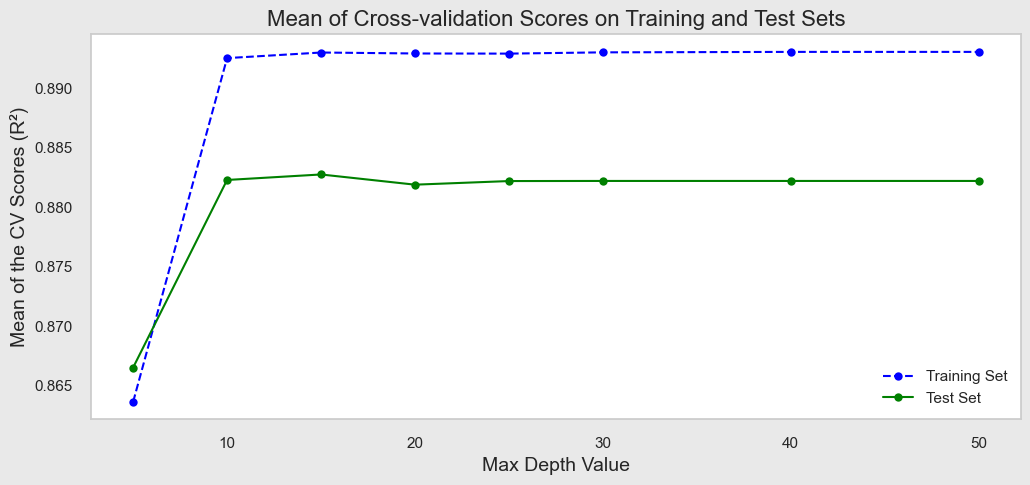

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Les meilleures paramètres pour les targets
{'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
********************************************************************************


In [1572]:
X_train, X_test, Y_train, Y_test = train_test_split(X, log_y, test_size=0.2, random_state=42)


param_grid = {'n_estimators': [10, 50, 100,200,300],
             'max_depth' : [None, 5, 10, 15,20],
             'min_samples_split': [2, 5, 10, 15],
             'min_samples_leaf' : [1, 2, 4, 6]}


# === Étape 3 : Visualisation ===
fig = plt.figure(figsize=[12, 5])
fig.patch.set_facecolor('#E0E0E0')
fig.patch.set_alpha(0.7)

plt.title("Mean of Cross-validation Scores on Training and Test Sets", size=16)
plt.plot(max_depth_values, mean_train_scores, label='Training Set', marker='o', linestyle='--', color='blue')
plt.plot(max_depth_values, mean_cv_scores, label='Test Set', marker='o', linestyle='-', color='green')

plt.grid()
plt.xlabel("Max Depth Value", size=14)
plt.ylabel("Mean of the CV Scores (R²)", size=14)
plt.legend(loc="best")
plt.show()


rand_forest = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator = rand_forest, param_grid = param_grid, cv = 5, 
                           n_jobs = -1, verbose = 2)
grid_search.fit(X_train_scaled, Y_train)
print('Les meilleures paramètres pour les targets')
print(grid_search.best_params_)
print("*"*80)


L'évaluation est fait sur les données du train et voie bien qu'à partir d'une profondeur de 15 le score devient stationnaire et le modèle n'apprend plus.

## Evaluation du modèle avec les meilleurs hyperparamètres

In [1575]:
y_pred = grid_search.best_estimator_.predict(X_test_scaled)
from sklearn.metrics import mean_squared_error as MSE
rmse_test = np.sqrt(MSE(Y_test, y_pred))
print("rmse_test: ", np.round(rmse_test, 2))
print("Score d'entrainement", grid_search.best_estimator_.score(X_train_scaled,Y_train))
print("Score pour la prédiction", grid_search.best_estimator_.score(X_test_scaled, Y_test))

rmse_test:  0.53
Score d'entrainement 0.9730380985820327
Score pour la prédiction 0.9061278560805698


L'optimisation des hyperparamètres permet de reduire de justesse le score d'entrainement et d'augmenter de justesse le score de test. Ce qui montre une amelioration de la performance du modèle.

## Features importance

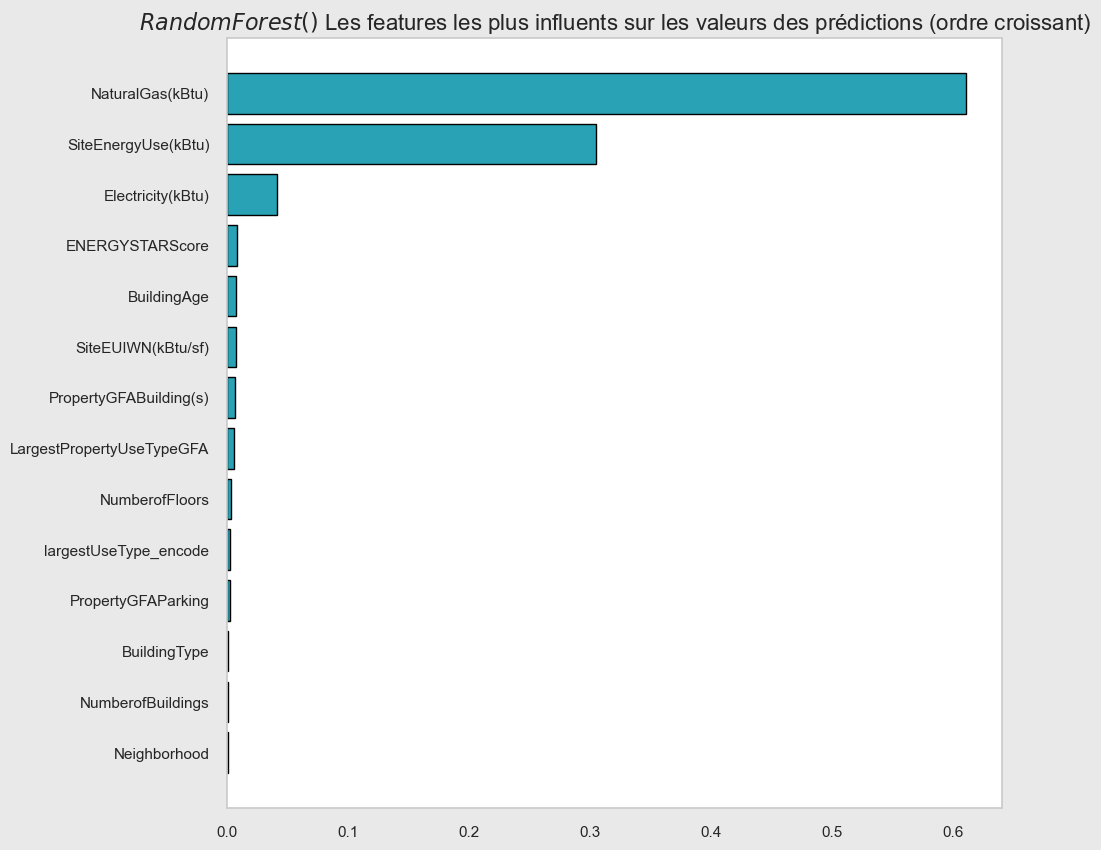

In [1578]:

# Création du modèle RandomForest
modelRandomForest = RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_leaf=2, min_samples_split=2)
modelRandomForest.fit(X_train_scaled, Y_train)

# Obtenir les importances des features
importances = modelRandomForest.feature_importances_

# Trier les indices des importances dans l'ordre croissant
indices = np.argsort(importances)

# Réorganiser les features et leurs importances en fonction du tri
sorted_features = X.columns[indices]
sorted_importances = importances[indices]

# Visualisation
fig = plt.figure(figsize=[10, 10])
fig.patch.set_facecolor('#E0E0E0')
fig.patch.set_alpha(0.7)
plt.title("$RandomForest()$ Les features les plus influents sur les valeurs des prédictions (ordre croissant)", size=16)
plt.barh(sorted_features, sorted_importances, color="#28a2b4", edgecolor='black')
plt.grid()
plt.show()


A l'issue de l'évalution de l'importance des variables , il ressort que les variables  
Le modèle RandomForestRegressor() montre que les features les plus participatives à la prédiction de l'émission du CO2 sont : NaturalGas(kBtu), SiteEnergyUse(kBtu),Electricity. Le reste contribue très faiblement parmi lesquelles figure la varible ENERGYSTARScore . Donc cette variable peut être delaissé car trop fastidieux en terme de calcul.

## Courbe d'apprentissage du modèle RandomForestRegressor

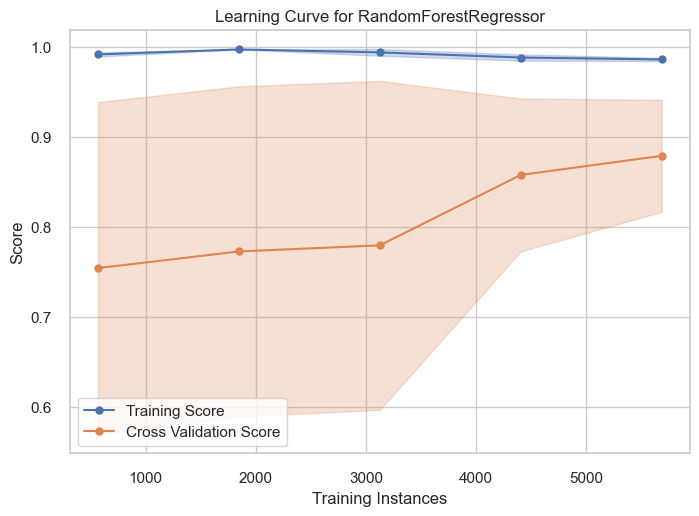

<Axes: title={'center': 'Learning Curve for RandomForestRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [1581]:


# Créer le visualiseur de courbe d'apprentissage
visualizer = LearningCurve(RandomForestRegressor(n_estimators=300, random_state=42), scoring='r2', random_state=42)

# Définir les tailles d'échantillon pour lesquelles afficher la courbe d'apprentissage
train_sizes = np.linspace(0.1, 1.0, 10) * len(X)

# Ajuster les données et afficher la courbe
visualizer.fit(X, log_y)
visualizer.show(train_sizes=train_sizes)


L'utilité de cette courbe est qu'elle montre la performance du modèle sur les données d'entraînement en fonction de la quantité de données d'entraînement utilisées. Elle est utilisée pour déterminer si le modèle est capable d'apprendre à partir des données d'entraînement et si la performance du modèle est suffisante. En général, on s'attend à ce que la performance du modèle sur les données d'entraînement augmente avec la quantité de données d'entraînement utilisées, car plus il y a de données d'entraînement, plus le modèle a l'occasion de s'ajuster.

La figure ci-dessus montre qu'à partir d'une taille des données d'entrainement de 5000, le modèle n'apprend plus la performance du modèle sur le train sans validation croisé devient stationnaire alors qu'on constate toujours amelioration du modèle sur le train avec validation croisé. Ainsi plus on augmente les données la performance du modèle va s'accroitre

## Evaluation de la puissance de prediction du modèle 

In [1584]:
# Créer le DataFrame avec les prédictions et les valeurs réelles
a = pd.DataFrame({
    'TotalGHGEmissions_Pred': y_pred,  # Ajouter les prédictions
    'TotalGHGEmissions': Y_test.values  # Ajouter les valeurs réelles
}, index=Y_test.index)  # Conserver les mêmes index que Y_test

# Afficher le DataFrame
print(a.head())



      TotalGHGEmissions_Pred  TotalGHGEmissions
4979                1.051465           1.029619
4447                1.645279           1.629241
4677                3.641211           3.925926
5273                3.815322           4.158883
3796                3.817020           3.394508


Text(0.5, 1.0, 'Comparaison entre valeurs réelles et celles prédites pour la target $TotalGHGEmissions$')

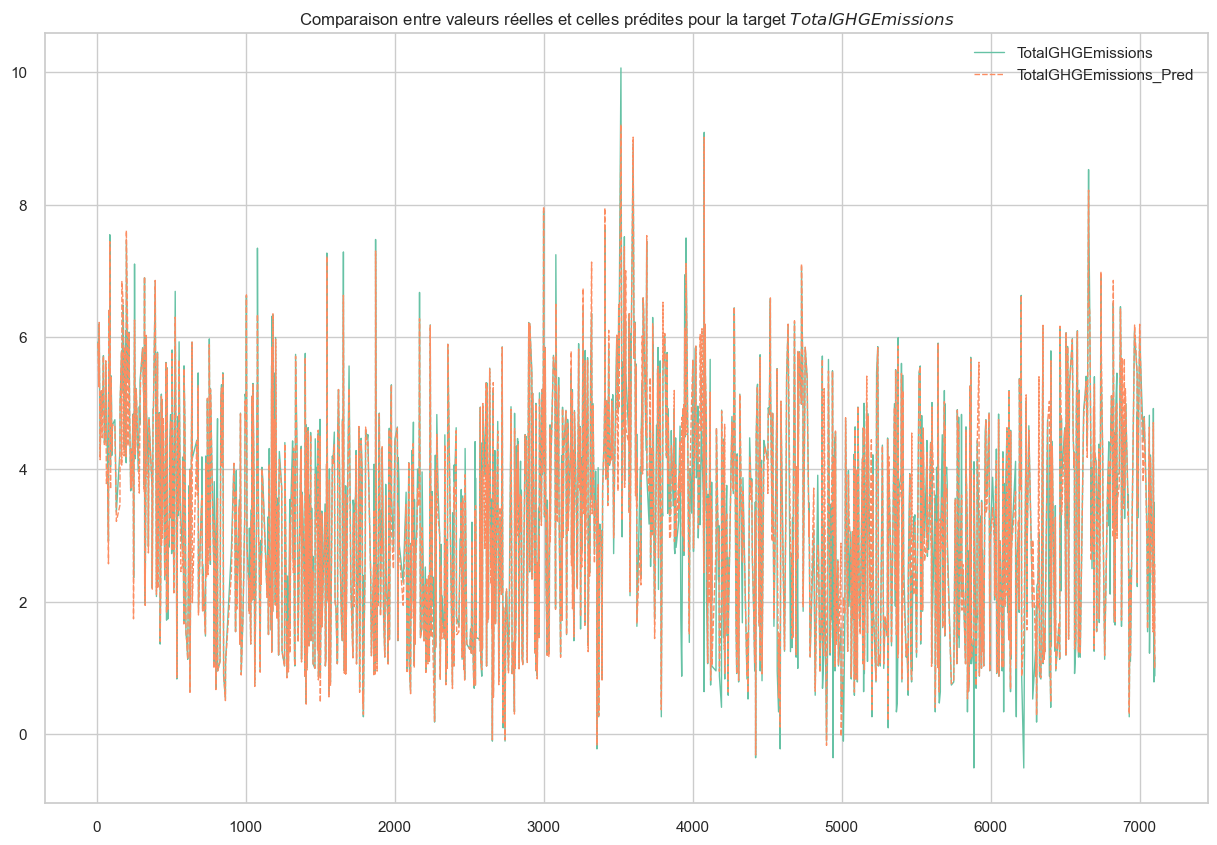

In [1585]:
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 10))
sns.lineplot(data=a[['TotalGHGEmissions','TotalGHGEmissions_Pred']],palette="Set2", linewidth=1)
plt.title("Comparaison entre valeurs réelles et celles prédites pour la target $TotalGHGEmissions$")


Nous constatons de bonnes prédictions pour notre variable cible TotalGHGEmissions . Les valeurs prédites suivent la même tendance que les valeurs réelles.

Error rate: 0.59 %


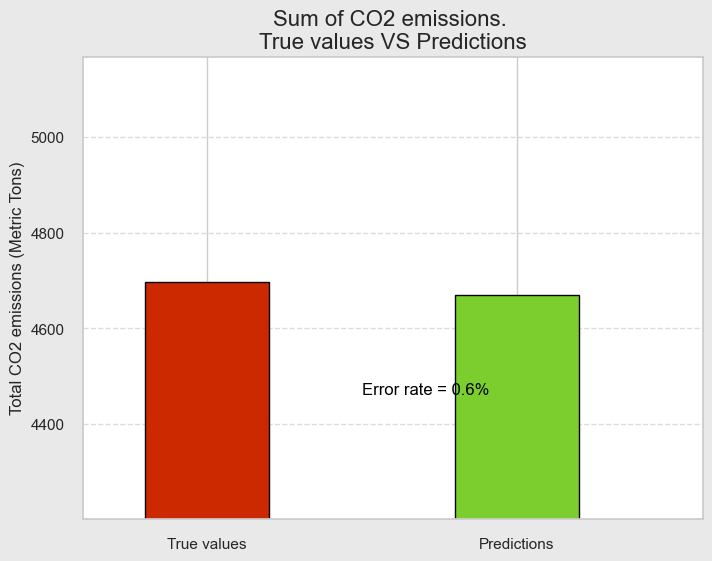

In [1587]:
# Calcul de l'erreur absolue en pourcentage
t, p = df_res["True values"].sum(), df_res["Predictions"].sum()
error = abs(t - p) / t * 100
print("Error rate:", round(error, 2), "%")

# Création de la figure
fig = plt.figure(figsize=[8, 6])  # Taille adaptée pour éviter le zoom excessif
fig.patch.set_facecolor('#E0E0E0')  # Couleur de fond
fig.patch.set_alpha(0.7)
plt.title("Sum of CO2 emissions. \nTrue values VS Predictions", size=16)

# Affichage des barres pour les vraies valeurs et les prédictions
plt.bar(
    x=[1, 2],
    height=[df_res["True values"].sum(), df_res["Predictions"].sum()],
    color=["#cc2900", "#7cce2e"],  # Rouge pour les valeurs vraies, vert pour les prédictions
    width=0.4,
    edgecolor="black"
)

# Ajout des étiquettes pour les barres
plt.xticks([1, 2], ["True values", "Predictions"])
plt.ylabel("Total CO2 emissions (Metric Tons)", size=12)

# Ajout du texte d'erreur
plt.text(1.5, max(t, p) * 0.95, "Error rate = {}%".format(round(error, 1)), size=12, color='black')

# Ajustement des limites pour l'axe X et Y
plt.ylim(min(t, p) * 0.9, max(t, p) * 1.1)
plt.xlim(0.6, 2.6)

# Grille et affichage final
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


Globalement l'erreur entre les valeurs predites et les valeurs réél est de 0,6%, qui est très faible vu la taille de notre jeux de données. Ainsi notre modèle est performant.